# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

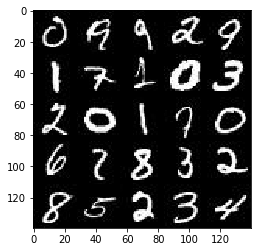

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

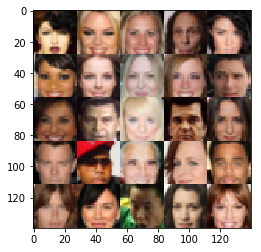

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #    print(images.get_shape())
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        #print ('Layer 1:', lrelu1.shape)
        # 14x14x64 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 14x14x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', lrelu3.shape)
        #7x7x256 now
        
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        #print ('Layer 1:', lrelu1.shape)
        # 4x4x256 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 8x8x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', h3.shape)
        # 16x16x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
        #print ('Output:', logits.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # Generator network 
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                              
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 1.8970
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 1.7493
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 3.6727
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 2.6254
Epoch 1/2... Discriminator Loss: 0.4162... Generator Loss: 2.9406
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 3.0507
Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 2.6742
Epoch 1/2... Discriminator Loss: 0.6527... Generator Loss: 9.9650
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 2.4709


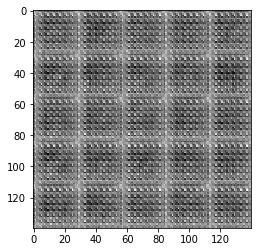

Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 2.5775
Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 3.1787
Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 2.1165
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 3.7427
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 1.7664
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 2.2701
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 2.4984
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 0.6591... Generator Loss: 2.5403
Epoch 1/2... Discriminator Loss: 0.7699... Generator Loss: 1.2417


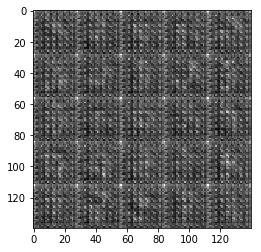

Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 2.0544
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 1.7038
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 4.3438
Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.5948
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 2.4947
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 1.6637
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.2919


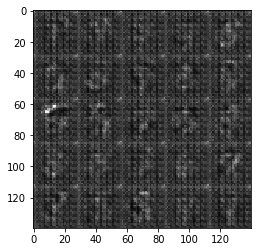

Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 2.0336
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.4662
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 1.7510
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 2.1774
Epoch 1/2... Discriminator Loss: 0.5665... Generator Loss: 2.4851
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.7615
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 2.6145
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.4035


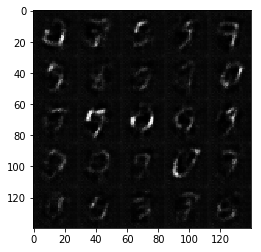

Epoch 1/2... Discriminator Loss: 0.7846... Generator Loss: 3.0906
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.2593
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 1.4231
Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.3985
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.7303
Epoch 1/2... Discriminator Loss: 2.7288... Generator Loss: 0.2200
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 2.4737
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.9019


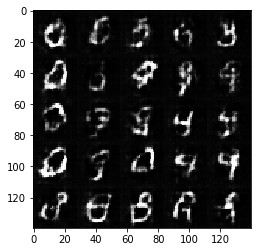

Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 1.8152
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.5869
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 1.7896
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.2753
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 1.7059
Epoch 1/2... Discriminator Loss: 0.5307... Generator Loss: 1.9985
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 1.6048
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 1.8341
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 1.9183
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.6693


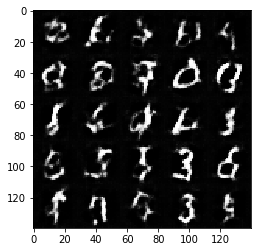

Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 2.8847
Epoch 1/2... Discriminator Loss: 0.6648... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.4447
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 2.6371
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.1696
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 2.0343


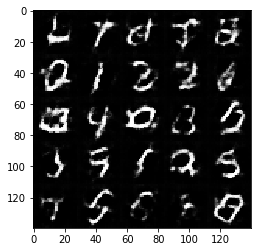

Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.7045
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.9196
Epoch 1/2... Discriminator Loss: 0.6514... Generator Loss: 1.9789
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.4648
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 2.1272
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 2.2139
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 1.2487


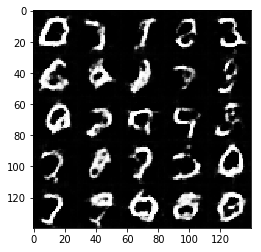

Epoch 1/2... Discriminator Loss: 0.7407... Generator Loss: 1.6671
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 1.9261
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 1.6708
Epoch 1/2... Discriminator Loss: 3.5558... Generator Loss: 6.1829
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.2474
Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 1.5842
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 0.9890


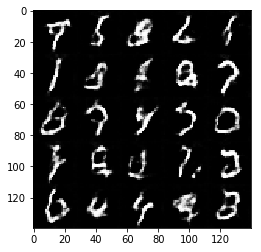

Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.2562
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 1.1643
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.3060
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 1.2636
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.2661
Epoch 1/2... Discriminator Loss: 0.7485... Generator Loss: 1.3879
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.9560


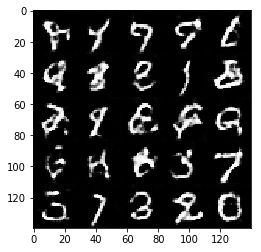

Epoch 1/2... Discriminator Loss: 2.3186... Generator Loss: 3.8574
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.1391... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 2.0577
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.5345
Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 2.0645
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 1.0703
Epoch 1/2... Discriminator Loss: 0.6859... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 3.3298


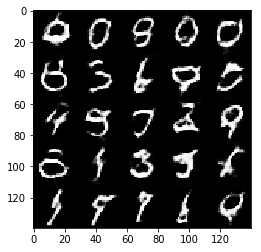

Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 0.6286... Generator Loss: 1.6084
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.4497
Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 1.6765
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.7548
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.6456
Epoch 1/2... Discriminator Loss: 0.5661... Generator Loss: 1.9897


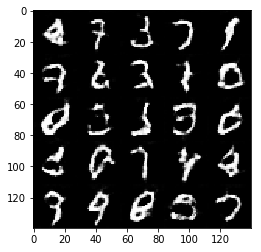

Epoch 1/2... Discriminator Loss: 4.8624... Generator Loss: 0.0293
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.5565
Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.4399
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.3097
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 1.8629
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.9425
Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 1.9206


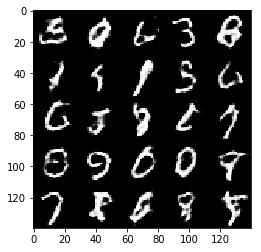

Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.3568
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 1.0146... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.6728
Epoch 1/2... Discriminator Loss: 0.7561... Generator Loss: 1.4493
Epoch 1/2... Discriminator Loss: 1.7404... Generator Loss: 4.3739
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.9471
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.9197


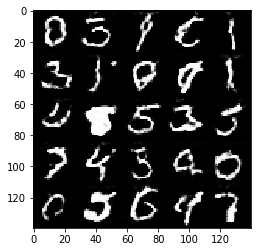

Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.2153
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.5558
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.7942
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.5299
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.5151
Epoch 1/2... Discriminator Loss: 0.7030... Generator Loss: 1.7287
Epoch 1/2... Discriminator Loss: 0.6567... Generator Loss: 1.7361
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 1.8397
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.7818


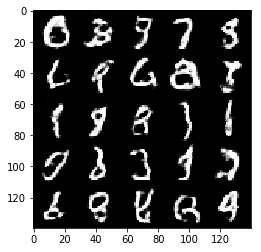

Epoch 1/2... Discriminator Loss: 1.7909... Generator Loss: 4.7812
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.4010
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.2347
Epoch 1/2... Discriminator Loss: 0.7552... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 1.3998
Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 1.9343
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 2.1810
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.3819
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.8114


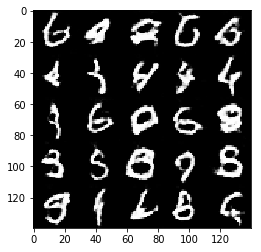

Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 0.6010... Generator Loss: 1.7225
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 1.4252
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.5297
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.4934
Epoch 1/2... Discriminator Loss: 0.5480... Generator Loss: 1.9831
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 1.4485
Epoch 1/2... Discriminator Loss: 1.7020... Generator Loss: 0.3915


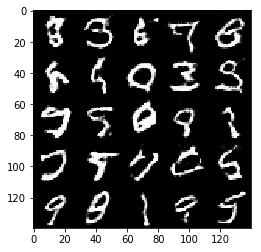

Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 2.6959
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.8281
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.7866
Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 1.9337
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 1.6091
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.4459
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.5347
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 1.1488


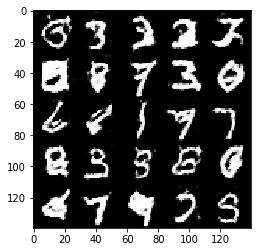

Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 1.9659
Epoch 1/2... Discriminator Loss: 1.7223... Generator Loss: 3.6008
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 1.2930
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 1.9393
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 1.7181
Epoch 1/2... Discriminator Loss: 0.6214... Generator Loss: 2.1768
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 2.5596
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.6444
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.1161


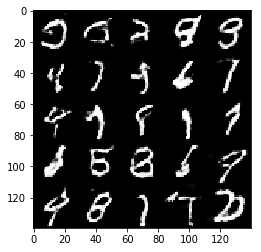

Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.7314
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0817
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.7868
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.7838
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 3.3506
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 2.2552
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 2.3536


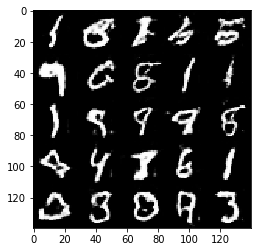

Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 0.5681... Generator Loss: 1.9000
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 2.1763
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.7000
Epoch 2/2... Discriminator Loss: 0.6010... Generator Loss: 1.7876
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.5141
Epoch 2/2... Discriminator Loss: 2.7990... Generator Loss: 0.1776
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 2.1702
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.6443
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.1409


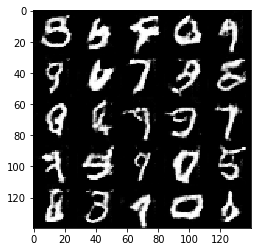

Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.2613
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.4931
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 2.0770
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 2.6990
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.5533
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.2654
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 0.8238


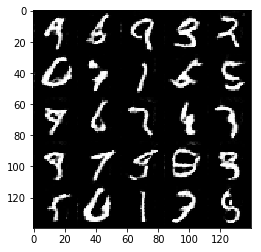

Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 2.8016
Epoch 2/2... Discriminator Loss: 0.6412... Generator Loss: 2.1837
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.6964
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.5516
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 0.7094... Generator Loss: 2.2597
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 1.9778


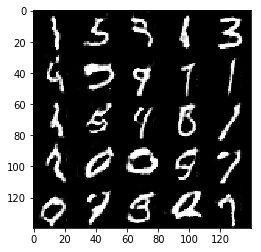

Epoch 2/2... Discriminator Loss: 0.9791... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 1.4650
Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.7583
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 0.6553... Generator Loss: 1.6897
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.2468
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.4453
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.9268
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.3995


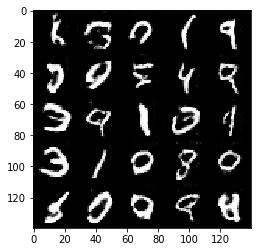

Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.5606
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.5183
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 2.0323
Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 1.2228
Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.7675
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.7298


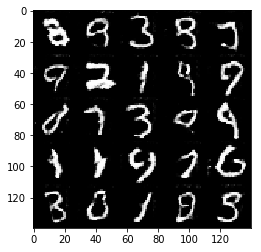

Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.4759
Epoch 2/2... Discriminator Loss: 0.7001... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 1.6159... Generator Loss: 0.5147
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 2.4444
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.5800
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.3482
Epoch 2/2... Discriminator Loss: 0.5224... Generator Loss: 2.2547


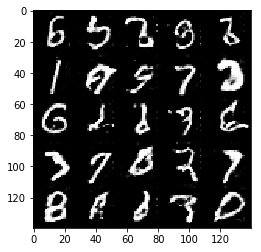

Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 2.0602
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 3.3010
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 2.8180
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 2.3880
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 1.5435
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.6864
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 2.2169
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.1351
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.1347


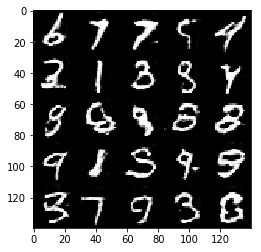

Epoch 2/2... Discriminator Loss: 1.8091... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.6323
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 2.2652
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.4890
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.5934
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 1.1740
Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.8867


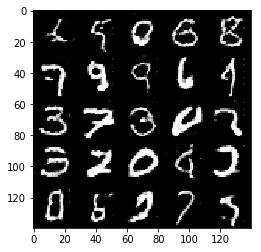

Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 2.0352
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 2.1308
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 1.8790
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.6060
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.2788
Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.7835
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 2.1117


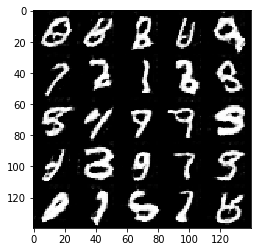

Epoch 2/2... Discriminator Loss: 0.6431... Generator Loss: 1.6384
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 2.0477
Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.8357... Generator Loss: 0.3834
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.4907
Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.7267
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 1.4698
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.0441


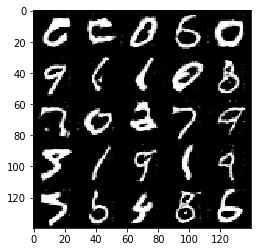

Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.5917
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 2.9563
Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 1.5858
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 2.2075
Epoch 2/2... Discriminator Loss: 2.1280... Generator Loss: 0.3050
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.4232
Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 2.3895
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.9643


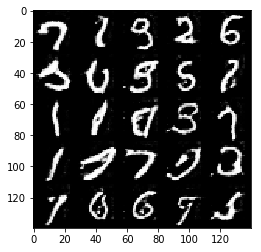

Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.4054
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 1.8268
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 2.4168
Epoch 2/2... Discriminator Loss: 1.7652... Generator Loss: 0.3961
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.2351
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.2355
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.4286
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 1.9494


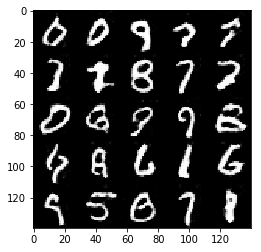

Epoch 2/2... Discriminator Loss: 0.5879... Generator Loss: 2.0774
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.4416
Epoch 2/2... Discriminator Loss: 0.7130... Generator Loss: 2.4676
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 2.4318
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 2.5078
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 2.1368
Epoch 2/2... Discriminator Loss: 0.4973... Generator Loss: 2.8139
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 1.2146
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 1.9327


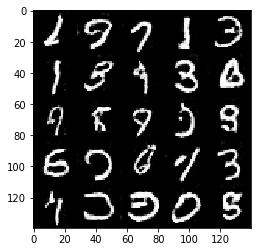

Epoch 2/2... Discriminator Loss: 4.2445... Generator Loss: 0.0604
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.3758
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 2.6362
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 2.1944
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.4648
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 1.8604
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 2.0187
Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 2.6031


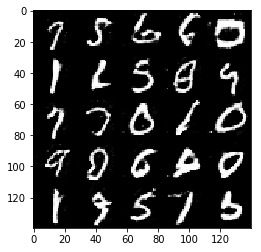

Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 1.3469
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 3.0509
Epoch 2/2... Discriminator Loss: 0.6932... Generator Loss: 2.1819
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 1.2475
Epoch 2/2... Discriminator Loss: 0.5422... Generator Loss: 2.1578
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 0.5848... Generator Loss: 1.9510
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.3828
Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 1.4713
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.6947


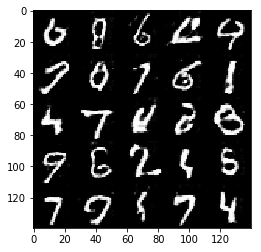

Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 2.9239
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.4965
Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 2.2031
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 1.9464
Epoch 2/2... Discriminator Loss: 0.6052... Generator Loss: 1.7263
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.0798
Epoch 2/2... Discriminator Loss: 0.6013... Generator Loss: 1.7922
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.6447


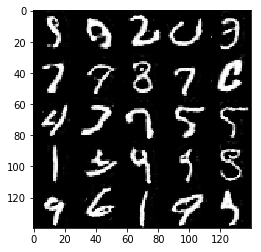

Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 2.0803
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.5854... Generator Loss: 1.7877
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 0.5190... Generator Loss: 2.1300
Epoch 2/2... Discriminator Loss: 0.4283... Generator Loss: 2.6996
Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 1.9699
Epoch 2/2... Discriminator Loss: 1.7895... Generator Loss: 0.4075
Epoch 2/2... Discriminator Loss: 0.5040... Generator Loss: 2.1857
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.4573


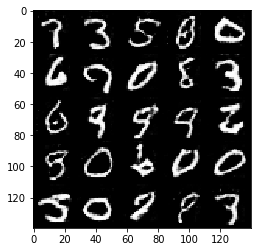

Epoch 2/2... Discriminator Loss: 0.5897... Generator Loss: 2.5805
Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.9443
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 3.0004
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 2.0302


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.9883
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 3.1305
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.0620


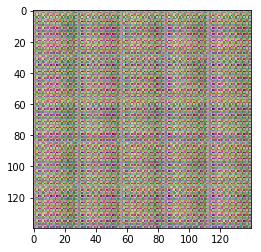

Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.1915
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 5.4550
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 2.8356
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 4.6562
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 2.9112
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 2.6127
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.8440
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 2.4560
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.2454


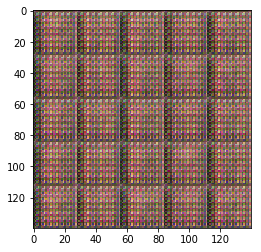

Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 3.2986
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 3.3629
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 9.2694
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.3634
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 4.0473
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.6469
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 2.3697
Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 3.3639
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.7069


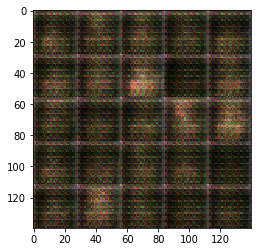

Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 2.3877
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 3.1955
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 3.3293
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.2259
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 2.6863
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 2.6052
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.6484
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.7340
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.3133


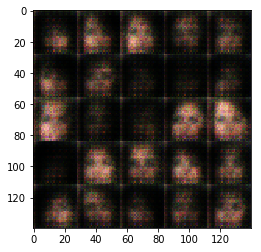

Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 2.7576
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 3.7740
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.8937
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 2.2338
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.9229
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.6198... Generator Loss: 3.7791
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 2.4737
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 2.7908


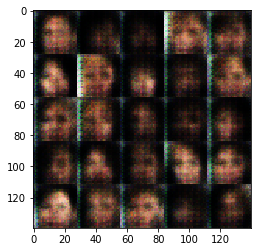

Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.1952
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 2.8018
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.6605
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 4.0719
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 2.8672
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.4176
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 2.1927
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.9245
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.9583


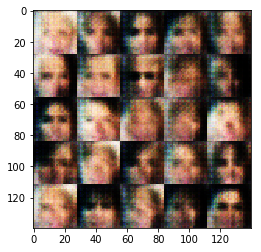

Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 2.9255
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 3.0617
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.4509
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 2.2900
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.3103
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 3.2949
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.3445


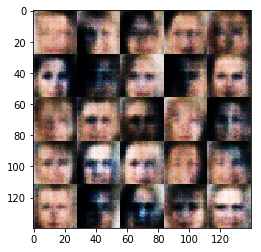

Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 1.9443
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 3.3639
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.9808
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 2.0004
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.7832
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.6220


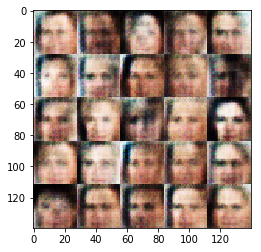

Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 2.6167
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 2.3613
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 3.3946
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 2.4921
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 2.8334
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 2.7280
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.6782


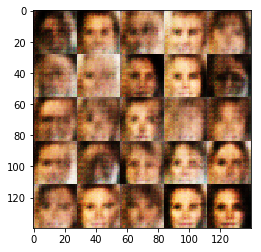

Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.6232
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 2.0532
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 2.3027
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.8750
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 2.2912
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.4592


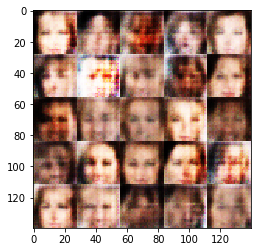

Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.0787
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.3893
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6897
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.4188
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 2.1063
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.4892


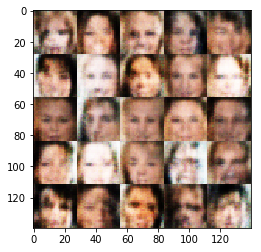

Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.9130
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 3.2108
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.3262
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 2.7401
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6368


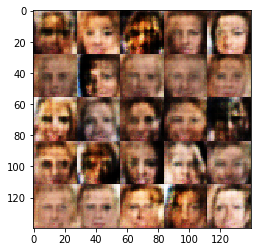

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 2.3556
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.0977
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 2.0325
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.0288
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 2.6813
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 3.0544
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.0391


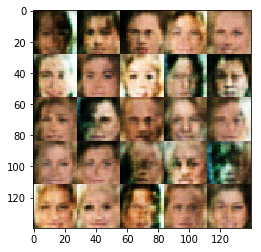

Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 2.0801
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 2.1037
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.5586


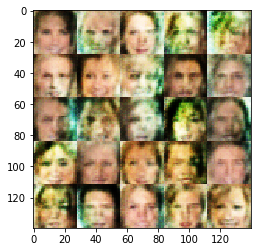

Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 3.1108
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 3.0639
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.9933
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.8683


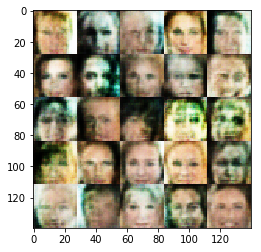

Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.8215
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.7654
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9210


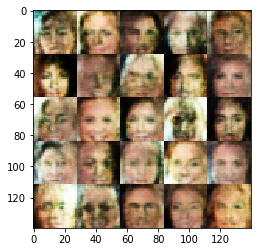

Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.4905
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.2299
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.5682
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.4152


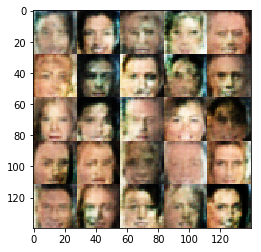

Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.5007
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 2.9778
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 2.3011
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 2.5364


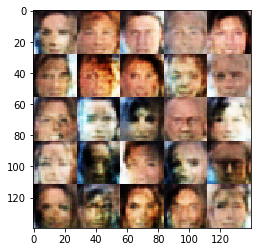

Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.8494
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 2.5691


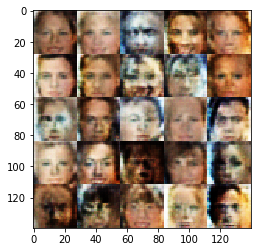

Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.7685
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.8646
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 2.1299
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 1.7054
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6623


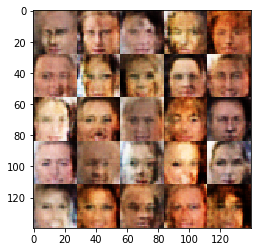

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.8729
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 2.0010
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.7470


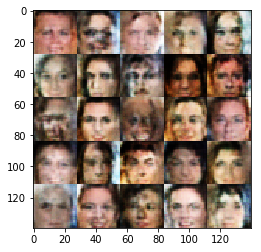

Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.8351
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.9976
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 2.9435
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.4973


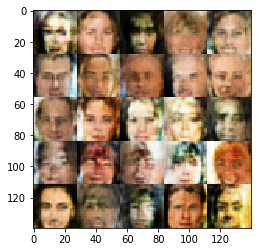

Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.7356
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.3589
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.9855


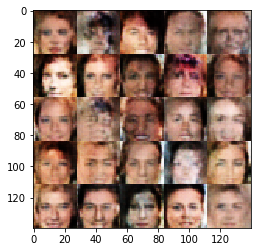

Epoch 1/1... Discriminator Loss: 1.7486... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 1.8256
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 2.6528
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.8476


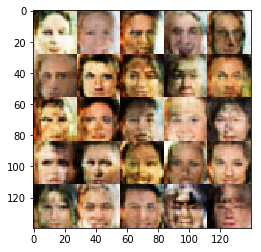

Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.4571
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.9158
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 2.2842


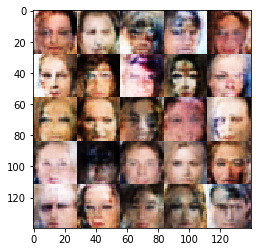

Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.7037
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.6837
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.0344


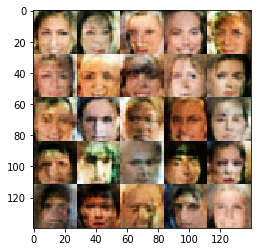

Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.6309
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.8010
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 1.5174


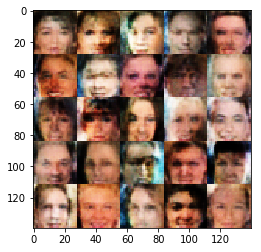

Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.7327
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 2.3763


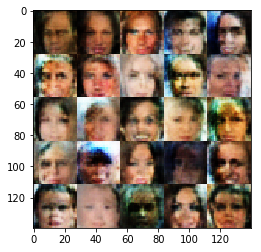

Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.5377
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 2.0230
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.4995


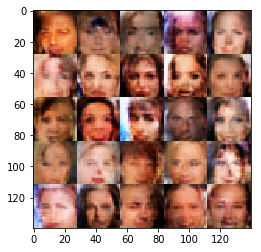

Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.2971


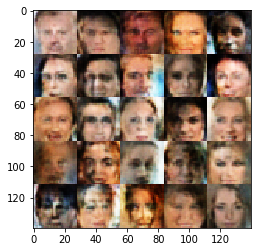

Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 2.9217
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.7894
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.4811


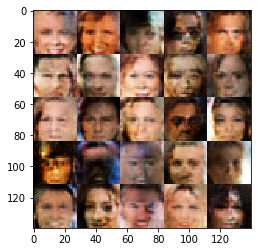

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.6896
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.5681


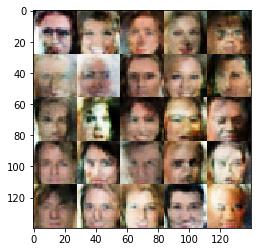

Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.2059


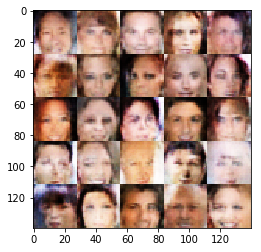

Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 2.1525
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.5971
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 3.1130
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.7243


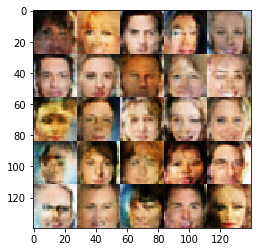

Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.4340
Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.9544
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.5448


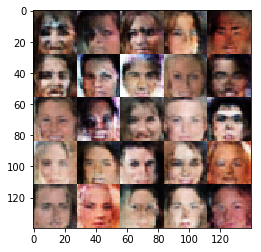

Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.9014
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.2317


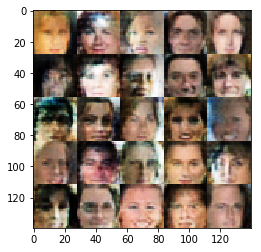

Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 2.0737
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.3734


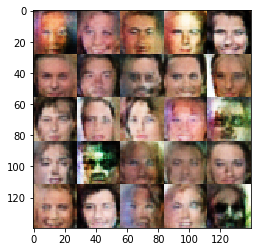

Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.2572
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.9753
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.5217


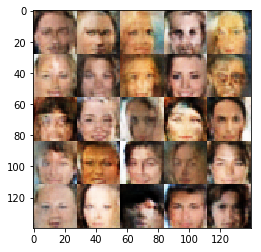

Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.4188
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 2.3064
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6683


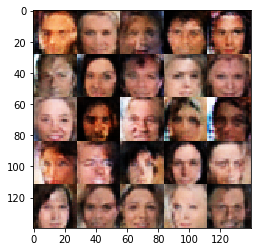

Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 2.4201
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.9140
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 1.1521


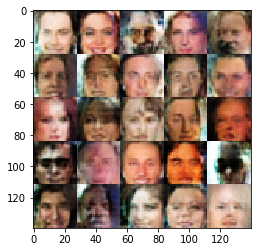

Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.8467
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.2093


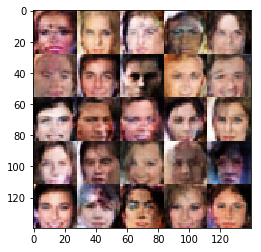

Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 2.1785
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.6191
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.9590
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.6064


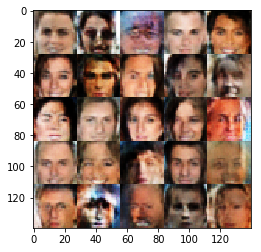

Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.8163... Generator Loss: 0.3075


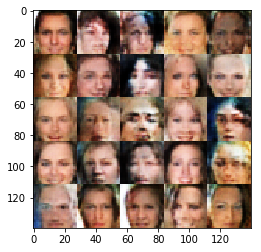

Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.9329
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.4054
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.7468


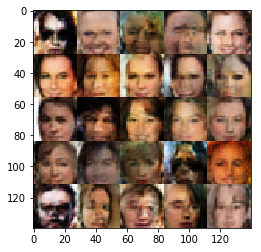

Epoch 1/1... Discriminator Loss: 1.7270... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.0778
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.8852


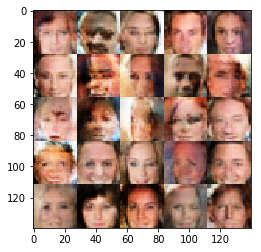

Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.5736


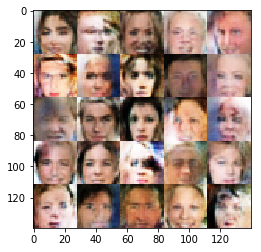

Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.6976
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9057


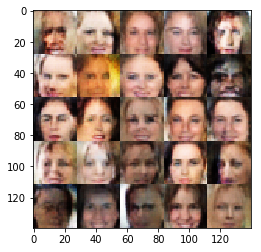

Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.4757
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.9810
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.4478


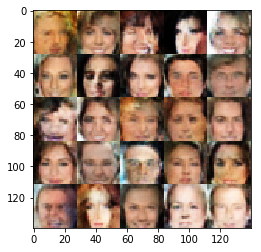

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.4430


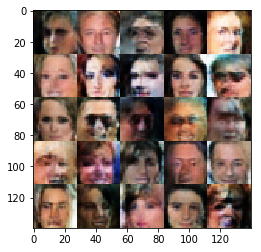

Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.4354


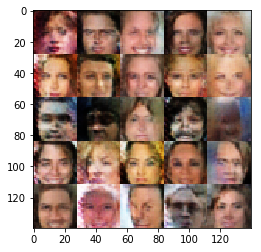

Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.1113
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 1.9032
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.3424
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5357


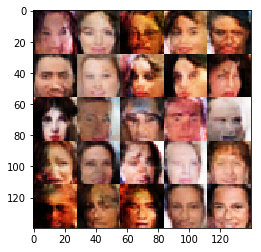

Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.8591
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 2.0072


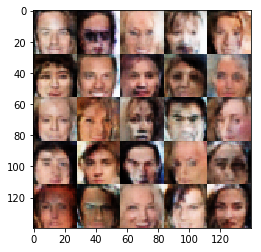

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.7724


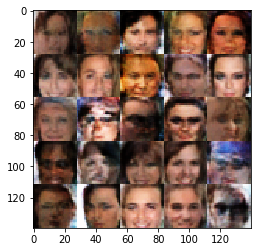

Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 2.0771
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.4876


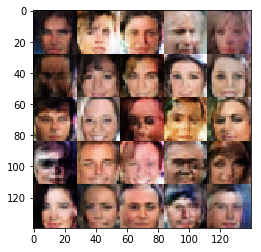

Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.3678


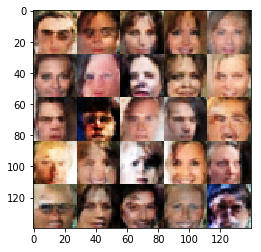

Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.4039


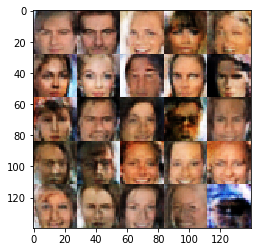

Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 2.4095
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.7301
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 0.9964


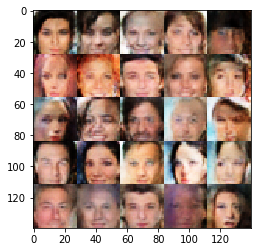

Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 2.3757
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.4174
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.0687


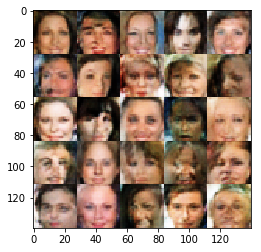

Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.5832
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.6659


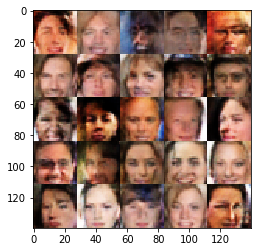

Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.4600
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.3362
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.3274


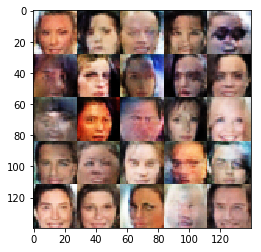

Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 2.1845
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 2.6039
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.9625
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.6762


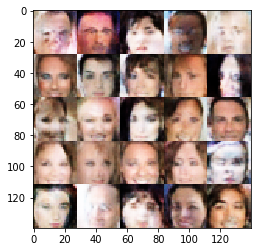

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.9687
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.8672


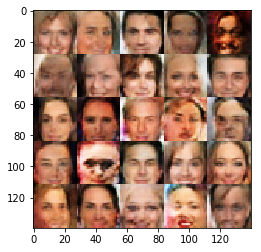

Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.1351


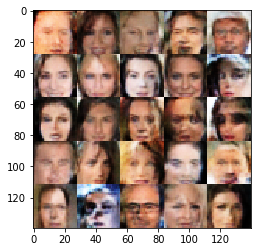

Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.6687
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 2.2746


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.